In [1]:
# import packages needed for entire model

import tensorflow as tf
from keras import layers, regularizers, metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from keras.backend import softsign
import shutil
import random
import sys
import h5py
from google.colab import drive
terminal = sys.stdout
# mount to google drive in order to pull data file
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Option 1 for running Network
# Takes Random Data of a specified size
subsetSize = 500
validationSize = 2000
splicingVal = 11
numOutputs = int(220/splicingVal)

# import data file, splice data, split into testing and training data
file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
imgs = hf['images'][()]
spectra = hf['spectra'][()]
atfrac = np.transpose(hf['atfrac'][()])
z = list(zip(imgs, spectra, atfrac))
badIndices = [i for i, each in enumerate(imgs) if np.sum(each[16:48][16:48]) > 2450 or round(np.sum(atfrac[i])) == 0]
badIndices.reverse()
for index in badIndices:
  del z[index]
random.shuffle(z)
imgs, spectra, atfrac = zip(*z)
imgs, spectra, atfrac  = np.array(imgs), np.array(spectra), np.array(atfrac)
spectra = np.array([x[::splicingVal] for x in spectra])
atfracNN = np.array(list(atfrac[0:subsetSize]))
imgsNN = np.array(list(imgs[0:subsetSize]))
spectraNN = np.array(list(spectra[0:subsetSize]))
atfrac_valid = np.array(list(atfrac[subsetSize:subsetSize+validationSize]))
x_valid = np.array(list(imgs[subsetSize:subsetSize+validationSize]))
y_valid = np.array(list(spectra[subsetSize:subsetSize+validationSize]))
del imgs, spectra, atfrac, z

In [19]:
# Rhiannon messing around hehe

def nonZeroInList(arr):
  return [[atfrac_keys[i], i, ele] for i, ele in enumerate(arr) if ele > 0.0]

file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
atfrac = np.transpose(hf['atfrac'][()])
#range(len(atfrac))


NameError: ignored

In [ ]:
# Option 2 for running Network
# Takes a specified minimum amount of each element up to 1077

minAmount = 300 #Max is 1077
maxAmount = minAmount*3 #Must be greater than minAmount. Set to -1 to not use
validationSize = 2000
splicingVal = 11

def nonZeroInList(arr):
  return [[atfrac_keys[i], i, ele] for i, ele in enumerate(arr) if ele > 0.0]

# mount to google drive in order to pull data file
file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
imgs = hf['images'][()]
spectra = hf['spectra'][()]
atfrac = np.transpose(hf['atfrac'][()])
atfrac_keys = hf['atfrac_keys']

# import data file, splice data, split into testing and training data
z = list(zip(imgs, spectra, atfrac))
badIndices = [i for i, each in enumerate(imgs) if np.sum(each[16:48][16:48]) > 2450 or round(np.sum(atfrac[i])) == 0]
badIndices.reverse()
for index in badIndices:
  del z[index]
random.shuffle(z)
imgs, spectra, atfrac = zip(*z)
imgs, spectra, atfrac  = np.array(imgs), np.array(spectra), np.array(atfrac)
spectra = [x[::splicingVal] for x in spectra]
numOutputs = int(220/splicingVal)
nonZeroList = [nonZeroInList(each) for each in atfrac]
oxideTracker = {}
indexListNN = []
indexList_valid = []

for i in range(len(atfrac)):
  oxideTracker[str(i)] = 0
for i, oxide in enumerate(nonZeroList):
  use = False
  overUsed = False
  for info in oxide:
    metal = info[1]
    if oxideTracker[str(metal)] < int(.75*minAmount):
      use = True
      break
    if maxAmount != -1 and oxideTracker[str(metal)] > maxAmount:
      use = False
      overUsed = True
    if oxideTracker[str(metal)] < minAmount and not overUsed:
      use = True
  if use:
    for info in oxide:
      metal = info[1]
      oxideTracker[str(metal)] += 1
    indexListNN.append(i)
  else:
    if len(indexList_valid) < validationSize:
      indexList_valid.append(i)
atfracNN, imgsNN, spectraNN, atfrac_valid, x_valid, y_valid = [], [], [], [], [], []
for index in indexListNN:
  atfracNN.append(atfrac[index])
  imgsNN.append(imgs[index])
  spectraNN.append(spectra[index])
for index in indexList_valid:
  atfrac_valid.append(atfrac[index])
  x_valid.append(imgs[index])
  y_valid.append(spectra[index])

atfracNN, imgsNN, spectraNN, atfrac_valid, x_valid, y_valid = np.array(atfracNN), np.array(imgsNN), np.array(spectraNN), np.array(atfrac_valid), np.array(x_valid), np.array(y_valid)
del imgs, spectra, atfrac, z, indexListNN, indexList_valid

In [ ]:
#For Max because he no longer has pro :(
subsetSize= 1000
validationSize = 2000
splicingVal = 11
numOutputs = int(220/splicingVal)

file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
#sample = hf["sample_id"][0:subsetSize + validationSize]
imgs = hf['images'][0:subsetSize + validationSize]
spectra = hf['spectra'][0:subsetSize + validationSize]
spectra = np.array([x[::splicingVal] for x in spectra])
imgsNN = imgs[0:subsetSize]
spectraNN = spectra[0:subsetSize]
x_valid = imgs[subsetSize:subsetSize+validationSize]
y_valid = spectra[subsetSize:subsetSize+validationSize]

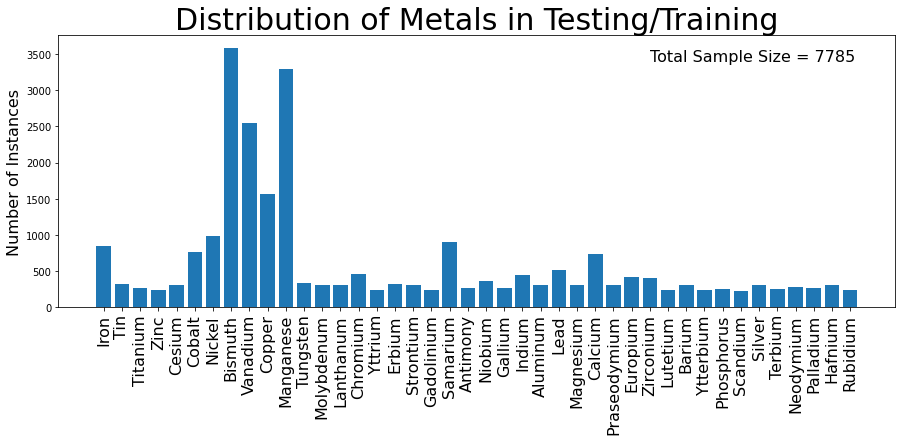

In [ ]:
# Use with either option, more applicable for Option 2
# BOTTOM GETS CUT OFF MUST MANUALLY SAVE IMAGE IF YOU WANT IT

def nonZeroInList(arr):
  return [[atfrac_keys[i], i, ele] for i, ele in enumerate(arr) if ele > 0.0]

atfrac_keys = hf['atfrac_keys']
nonZeroList = [nonZeroInList(each) for each in atfracNN]
dic = {}
for i in range(42):
  dic[str(i)] = 0
for nonZero in nonZeroList:
  for info in nonZero:
    metal = info[1]
    dic[str(metal)] += 1
#for i in range(42):
#  print(i, dic[str(i)])
f, axs = plt.subplots(figsize = (15,5))
oxides = 'Iron, Tin, Titanium, Zinc, Cesium, Cobalt, Nickel, Bismuth, Vanadium, Copper, Manganese, Tungsten, Molybdenum, Lanthanum, Chromium, Yttrium, Erbium, Strontium, Gadolinium, Samarium, Antimony, Niobium, Gallium, Indium, Aluminum, Lead, Magnesium, Calcium, Praseodymium, Europium, Zirconium, Lutetium, Barium, Ytterbium, Phosphorus, Scandium, Silver, Terbium, Neodymium, Palladium, Hafnium, Rubidium'
oxides = oxides.split(', ')
axs.bar(oxides, dic.values())
axs.set_xticklabels(oxides, rotation = 90, fontsize = 16)
axs.set_ylabel('Number of Instances', fontsize = 16)
axs.set_title('Distribution of Metals in Testing/Training', fontsize = 30)
axs.text(30, 3400, f"Total Sample Size = {len(imgsNN)}", fontsize = 16)

plt.show()

f.savefig('SpecificData.jpg')

In [ ]:
# Current Neural Network Model function

def get_conv_model_normal():

    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(units=numOutputs, activation = 'sigmoid')])
    model.summary()
    adamOpti = tf.keras.optimizers.Adam(lr = 0.001)
    model.compile(optimizer= adamOpti, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [ ]:
# Load Maggie's Model
validationSize = 2000

dataSet = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(dataSet, 'r')
imgs = hf['images'][()]
spectra = hf['spectra'][()]
atfrac = np.transpose(hf['atfrac'][()])
z = list(zip(imgs, spectra, atfrac))
badIndices = [i for i, each in enumerate(imgs) if np.sum(each[16:48][16:48]) > 2450 or round(np.sum(atfrac[i])) == 0]
badIndices.reverse()
for index in badIndices:
  del z[index]
random.shuffle(z)
imgs, spectra, atfrac = zip(*z)
imgs, spectra, atfrac  = np.array(imgs), np.array(spectra), np.array(atfrac)
spectra = np.array([x[::splicingVal] for x in spectra])
atfrac_valid = np.array(list(atfrac[:validationSize]))
x_valid = np.array(list(imgs[:validationSize]))
y_valid = np.array(list(spectra[:validationSize]))
del imgs, spectra, atfrac, z
#for model in range()
modelList = []
normal_model = get_conv_model_normal()
path = "/content/drive/My Drive/Colab Notebooks/MaggieCheckpoints/checkpoint.h5"
normal_model.load_weights(path)
modelList.append(normal_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 dense_7 (Dense)             (None, 62, 62, 256)       16640     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 256)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 31, 31, 256)       0         
                                                                 
 flatten_2 (Flatten)         (None, 246016)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               62980352  
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Running Neural Network with averaging Ensemble, including early stopping

# Define number of networks, batches, and epochs

numNetworks = 10
epochs = 50
batch_size = 32

# Run Neural Network for the desired number of networks in the ensemble (numNetworks)


modelList = []
historyList= []

data = ShuffleSplit(n_splits=numNetworks, random_state=0, test_size=0.20, train_size=None)
data.get_n_splits(imgsNN, spectraNN)
for train_index, test_index in data.split(imgsNN, spectraNN):
  x_train, x_test = imgsNN[train_index], imgsNN[test_index]
  y_train, y_test = spectraNN[train_index], spectraNN[test_index]
  normal_model = get_conv_model_normal()
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
  normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, validation_data = (x_test, y_test), verbose = 1,
                callbacks= [early_stopping])
  modelList.append(normal_model)
  historyList.append(normal_history)


# Create predictions based on results of the neural network and ensemble

def makePredictionsList(modelList, data):
  return [model.predict(data) for model in modelList]

# Create the geometric average of the output spectra from the predicted values from the ensemble

def ensemblePredictGeoAverage(predictList, ele):
  numNetworks = len(predictList)
  prediction = 1
  for predict in predictList:
    prediction *= np.abs(predict[ele])
  return prediction**(1/numNetworks)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 dense (Dense)               (None, 62, 62, 256)       16640     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 256)       0         
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense_1 (Dense)             (None, 256)               62980352  
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
195/195 [==============================] - 20s 41ms/step - loss: 0.1180 - mean_squared_error: 0.1180 - val_loss: 0.0938 - val_mean_squared_error: 0.0938
Epoch 2/50
195/195 [==============================] - 7s 38ms/step - loss: 0.0851 - mean_squared_error: 0.0851 - val_loss: 0.0680 - val_mean_squared_error: 0.0680
Epoch 3/50
195/195 [==============================] - 7s 38ms/step - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0680 - val_mean_squared_error: 0.0680
Epoch 4/50
195/195 [==============================] - 7s 38ms/step - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0680 - val_mean_squared_error: 0.0680
Epoch 5/50
195/195 [==============================] - 8s 39ms/step - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0680 - val_mean_squared_error: 0.0680
Epoch 6/50
195/195 [==============================] - 8s 39ms/step - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0680 - val_mean_squared_error: 0.0680
Epoch 7/50
195/195 [=

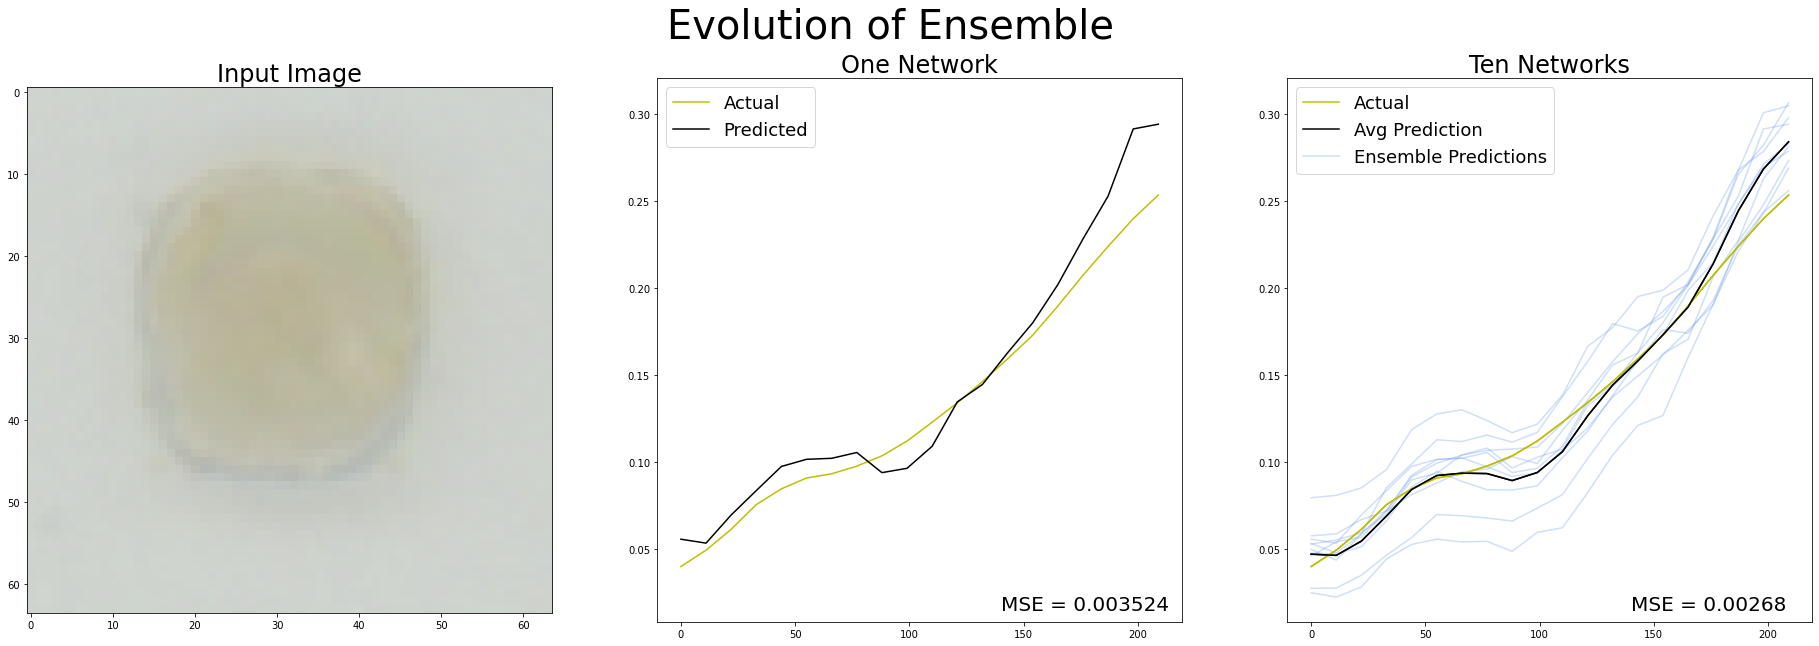

In [ ]:
# Create comparison graph of the actual spectra (blue), each networks predicted spectra (yellow), and the final averaged prediction (black)

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y_pred = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
fig, axs = plt.subplots(1, 3, figsize=(32, 10))

axs[1].get_shared_y_axes().join(axs[1], axs[2])
axs[1].get_shared_x_axes().join(axs[1], axs[2])

# Image
axs[0].imshow(x_valid[-4])
axs[0].set_title('Input Image', fontsize = 24)

# Single Plot
#axs[1].set_ylim(bottom=0, top=0.35)

axs[1].plot(x, y_valid[-4], color = 'y')
axs[1].plot(x, predictList[5][-4], color = 'black')
axs[1].legend(['Actual', 'Predicted'], loc = 'upper left', prop={'size': 18})
axs[1].set_title('One Network', fontsize = 24)
axs[1].text(140, 0.015, f"MSE = {round(float(np.mean((predictList[5] - y_valid)**2)), 6)}", fontsize = 20)


# Ensemble Plot
#axs[2].set_ylim(bottom=0, top=0.35)

axs[2].plot(x, y_valid[-4], color = 'y')
axs[2].plot(x,y_pred[-4], color = 'black')

for predict in predictList:
  axs[2].plot(x, predict[-4], color = 'cornflowerblue', alpha = .3)

axs[2].plot(x, y_valid[-4], color = 'y')
axs[2].plot(x,y_pred[-4], color = 'black')
axs[2].legend(['Actual', 'Avg Prediction', 'Ensemble Predictions'], loc = 'upper left', prop={'size': 18})

axs[2].text(140, 0.015, f"MSE = {round(float(np.mean((y_pred - y_valid)**2)), 6)}", fontsize = 20)
axs[2].set_title('Ten Networks', fontsize = 24)

fig.suptitle('Evolution of Ensemble', fontsize = 40)
plt.show()

fig.savefig('PredictCompare.jpg')

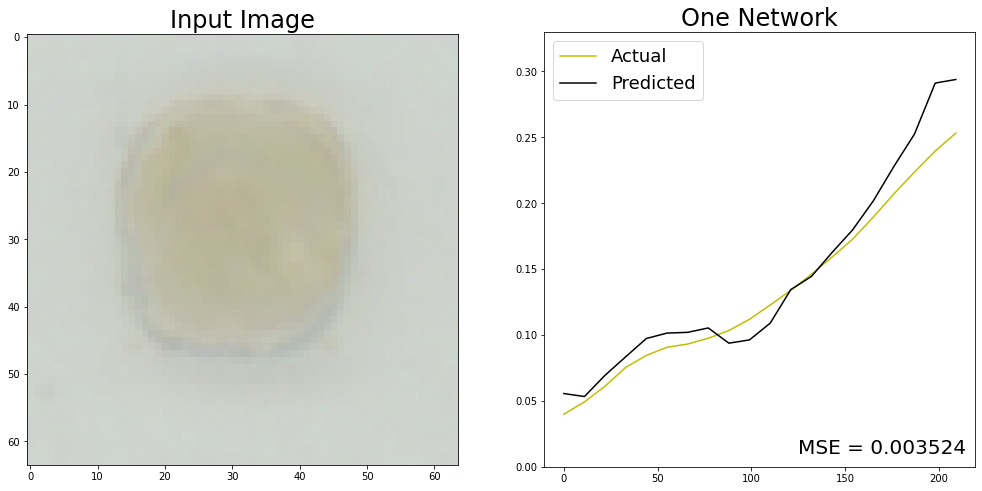

In [ ]:
# Create comparison graph of the actual spectra (blue), each networks predicted spectra (yellow), and the final averaged prediction (black)
# single network comparison only

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y_pred = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
fig, axs = plt.subplots(1, 2, figsize=(17, 8))

#axs[1].get_shared_y_axes().join(axs[1], axs[2])
#axs[1].get_shared_x_axes().join(axs[1], axs[2])

# Image
axs[0].imshow(x_valid[-4])
axs[0].set_title('Input Image', fontsize = 24)

# Single Plot
axs[1].set_ylim(bottom=0, top=0.33)

axs[1].plot(x, y_valid[-4], color = 'y')
axs[1].plot(x, predictList[5][-4], color = 'black')
axs[1].legend(['Actual', 'Predicted'], loc = 'upper left', prop={'size': 18})
axs[1].set_title('One Network', fontsize = 24)
axs[1].text(125, 0.01, f"MSE = {round(float(np.mean((predictList[5] - y_valid)**2)), 6)}", fontsize = 20)


# Ensemble Plot
#axs[2].set_ylim(bottom=0, top=0.35)

#axs[2].plot(x, y_valid[-7], color = 'y')
#axs[2].plot(x,y_pred[-7], color = 'black')

#for predict in predictList:
#  axs[2].plot(x, predict[-7], color = 'cornflowerblue', alpha = .3)

#axs[2].plot(x, y_valid[-7], color = 'y')
#axs[2].plot(x,y_pred[-7], color = 'black')
#axs[2].legend(['Actual', 'Avg Prediction', 'Ensemble Predictions'], loc = 'upper left', prop={'size': 18})

#axs[2].text(140, 0.015, f"MSE = {round(float(np.mean((y_pred - y_valid)**2)), 6)}", fontsize = 20)
#axs[2].set_title('Ten Networks', fontsize = 24)

#fig.suptitle('Evolution of Ensemble', fontsize = 40)
plt.show()

fig.savefig('PredictCompare2.jpg')

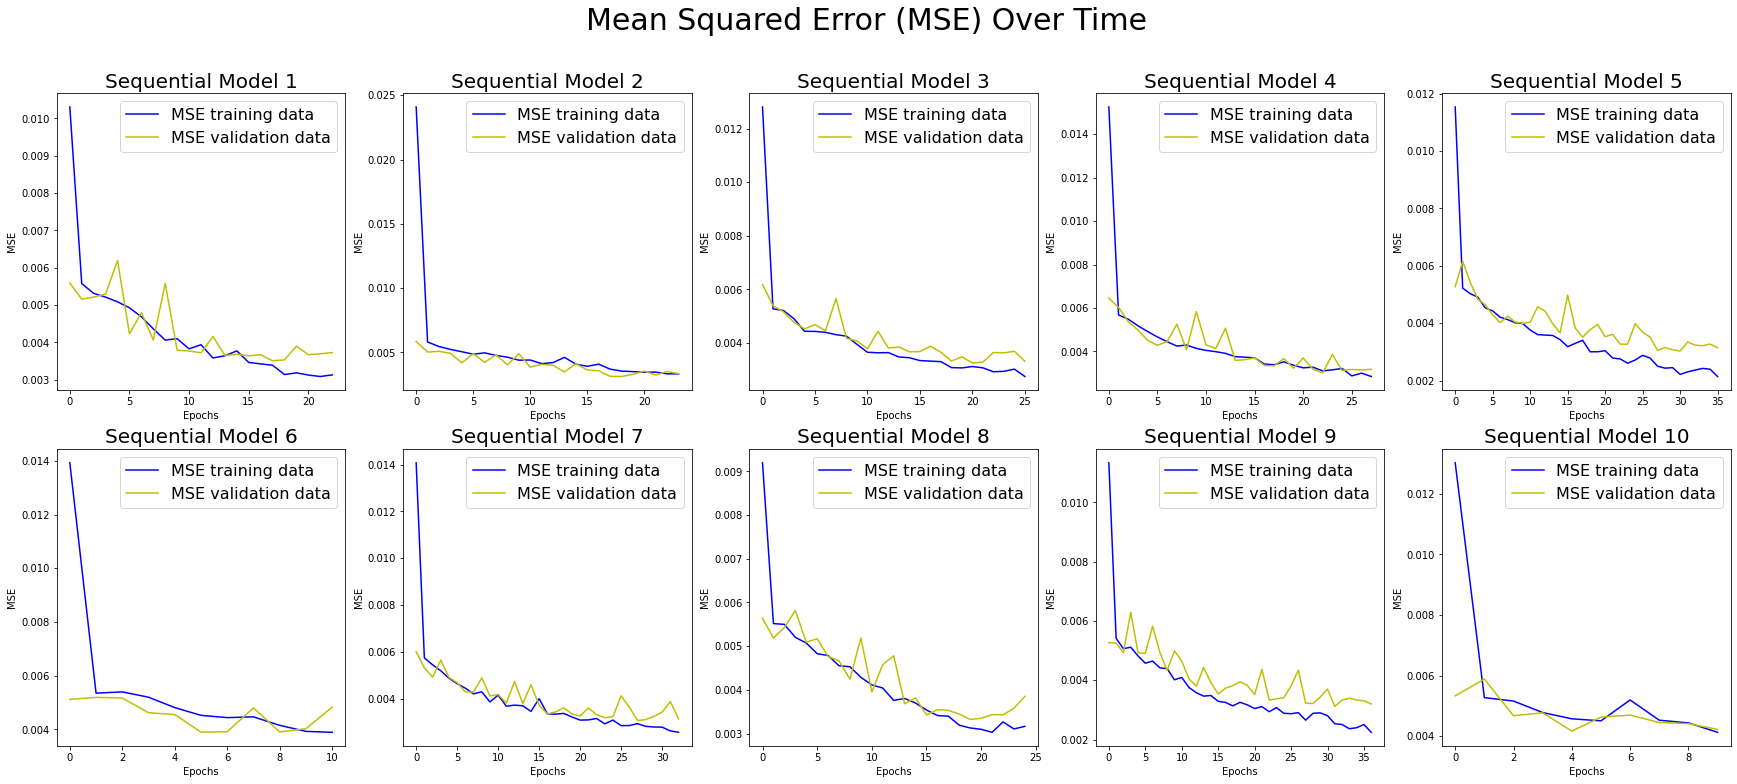

In [ ]:
# Get MSE Plot

from IPython.core.pylabtools import figsize
def closest_factor(num):
  n = int(np.ceil(np.sqrt(num)))
  if num % n == 0:
    return n, n
  else:
    n+=1
    while num % n != 0:
      n+=1
    return int(num/n), n

low, high = closest_factor(numNetworks)
fig = plt.figure(1, figsize = (6*high,6*low))
plt.title('Mean Squared Error (MSE) Over Time', fontsize = 30)
for i in range(low):
  for j in range(high):
    index = high*i + j
    y = historyList[index].history
    plt.subplot(low, high, index+1)
    plt.plot(y['mean_squared_error'], color = 'b')
    plt.plot(y['val_mean_squared_error'], color = 'y')
    plt.legend(['MSE training data', 'MSE validation data'], prop={'size': 16})
    plt.title(f'Sequential Model {index+1}', fontsize = 20)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
fig.suptitle('Mean Squared Error (MSE) Over Time', fontsize = 30)

plt.savefig('MSE_Plot.jpg')

63/63 [==============================] - 1s 9ms/step


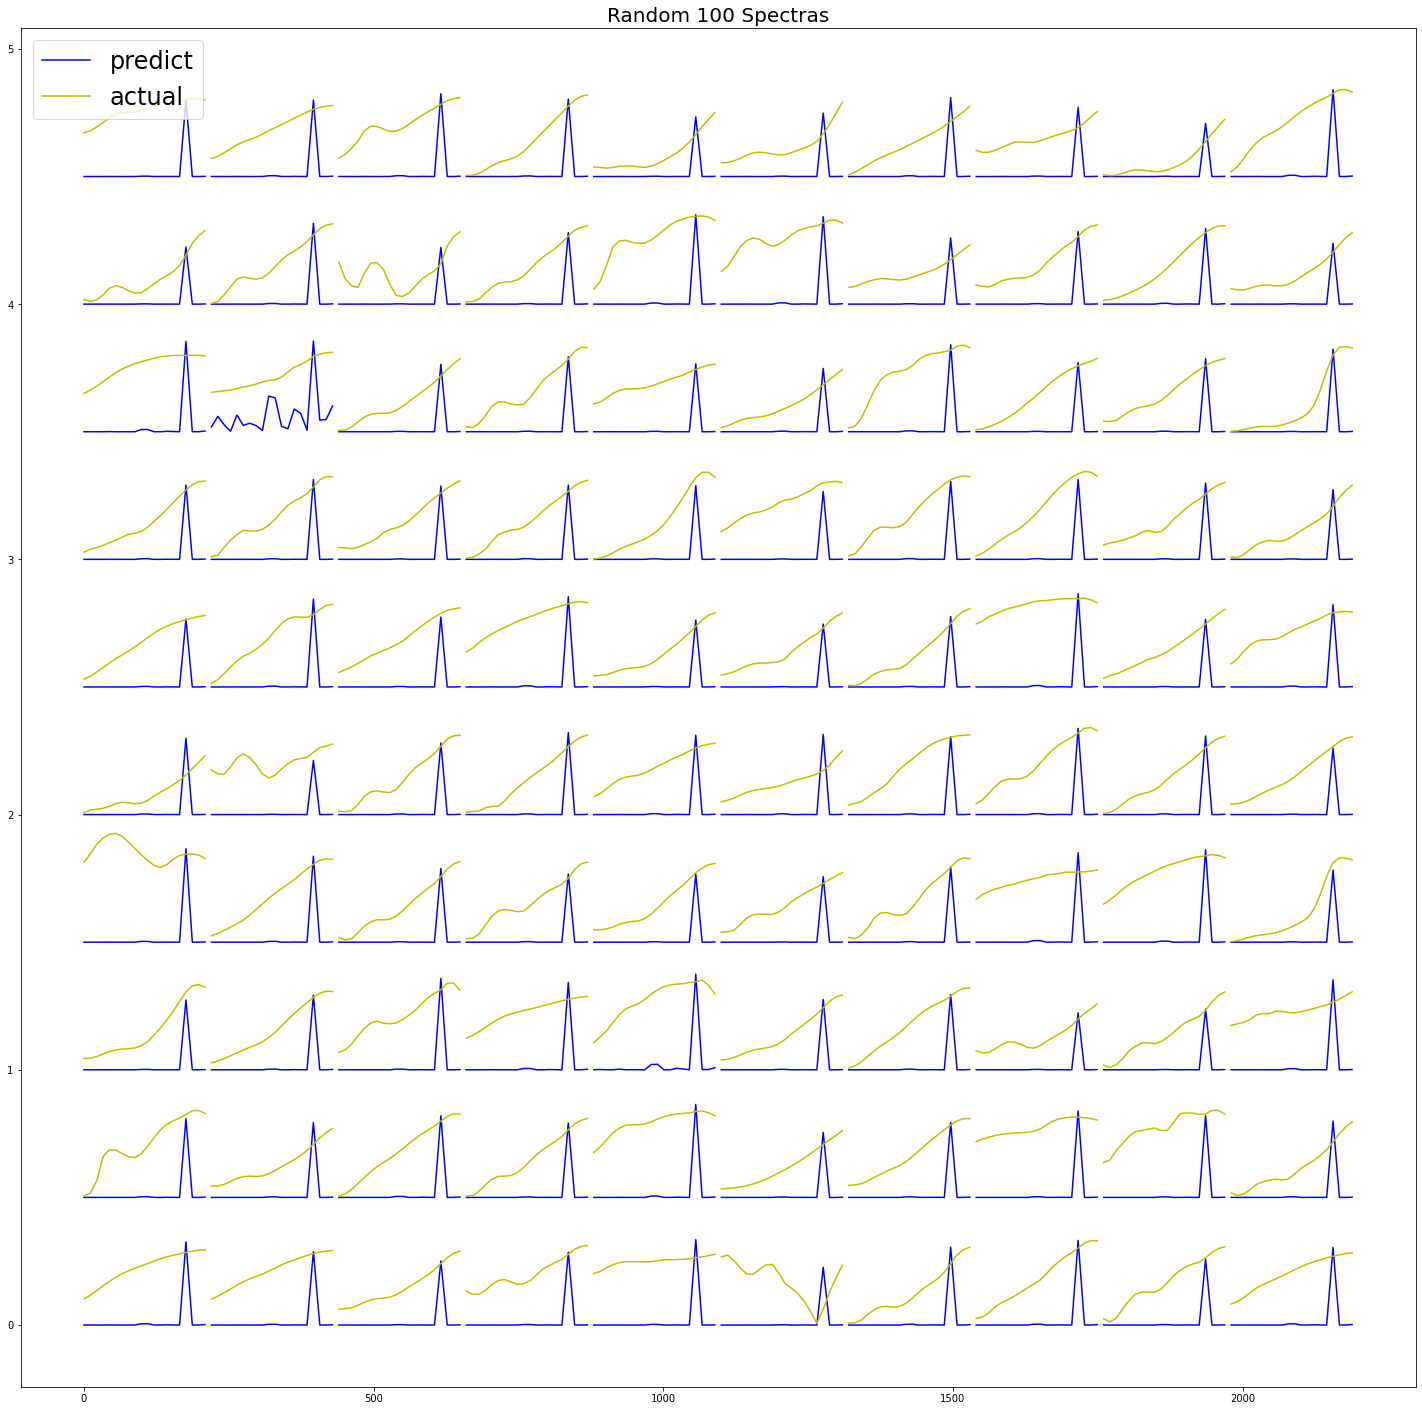

In [ ]:
# Creates Random 100 Grid of Spectras from Validation Data

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
rando = [x for x in range(len(y))]
random.shuffle(rando)
fig = plt.figure(figsize=(25, 25))
for j in range(10):
  for i in range(10):
    rand = rando[10*j + i]
    plt.plot(x + 220*i, y[rand]+.5*j, color = 'b')
    plt.plot(x + 220*i, y_valid[rand]+.5*j, color = 'y')
    i+=1
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Random 100 Spectras', fontsize = 20)
plt.savefig('Random100Grid.jpg')
plt.show()

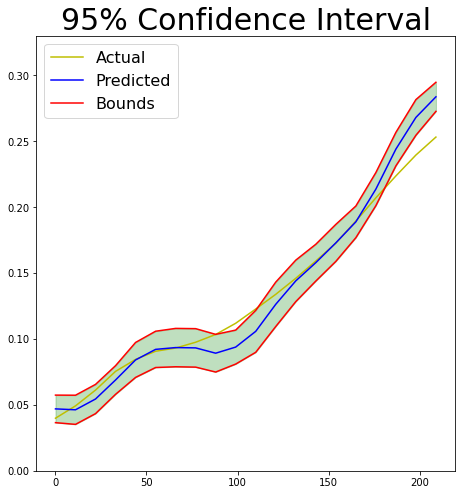

In [ ]:
# New Confidence interval without hardcoded range and t interval


# Show the confidence interval on the ensemble average prediction
CI = {
 '95%': 2.26216,

}
def ensembleUncertainty(predictList, ele):
  newPredict = np.transpose(predictList, (1, 2, 0))
  return np.array([np.std(output) for output in newPredict[ele]])

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])

fig, ax = plt.subplots(1, len(CI), figsize=(7.5, 8))
ax.set_ylim(bottom=0, top=0.33)


i = -4

for perc, val in CI.items():
# Plot lines
  ax.plot(x, y_valid[i], color = 'y')
  ax.plot(x, y[i], color="blue")

  topUQ = y[i]+val*(UQ[i]/np.sqrt(numNetworks))
  botUQ = y[i]-val*(UQ[i]/np.sqrt(numNetworks))
  ax.plot(x, topUQ, color="red")
  ax.plot(x, botUQ, color="red")

  # Fill area when income > expenses with green
  ax.fill_between(
      x, topUQ, botUQ, where=(topUQ > botUQ),
      interpolate=True, color="green", alpha=0.25,
      label="Positive"
  )


  ax.set_title(f'{perc} Confidence Interval', fontsize = 30)
  ax.legend(['Actual', 'Predicted', 'Bounds'], fontsize = 16)

fig.savefig('Confidence.jpg')

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-9212f489-7512-b53e-db6d-5cb9b9c459e4)


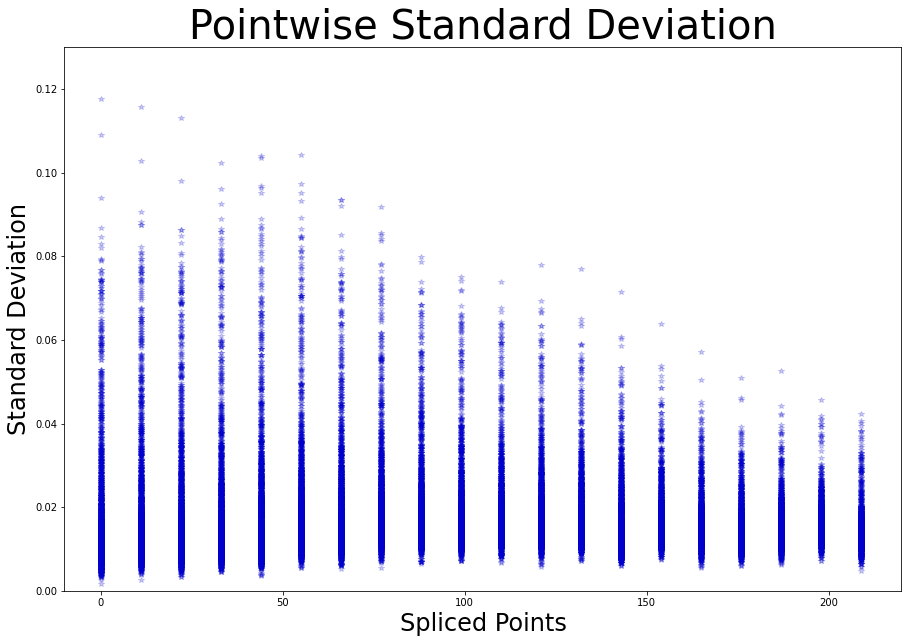

In [ ]:
# Pointwise SD Graph

def ensembleUncertainty(predictList, ele):
  newPredict = np.transpose(predictList, (1, 2, 0))
  return np.array([np.std(output) for output in newPredict[ele]])

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y_pred = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])

fig = plt.figure(figsize=(15, 10))
plt.axis([-10,220, 0, .13])
for i in range(len(x_valid)):
  plt.plot(x, UQ[i], '*', color = 'mediumblue', alpha = 0.2)
plt.title('Pointwise Standard Deviation', fontsize = 40)
plt.xlabel('Spliced Points', fontsize = 24)
plt.ylabel('Standard Deviation', fontsize = 24)
plt.savefig('PointWiseSTD.jpg')
plt.show()

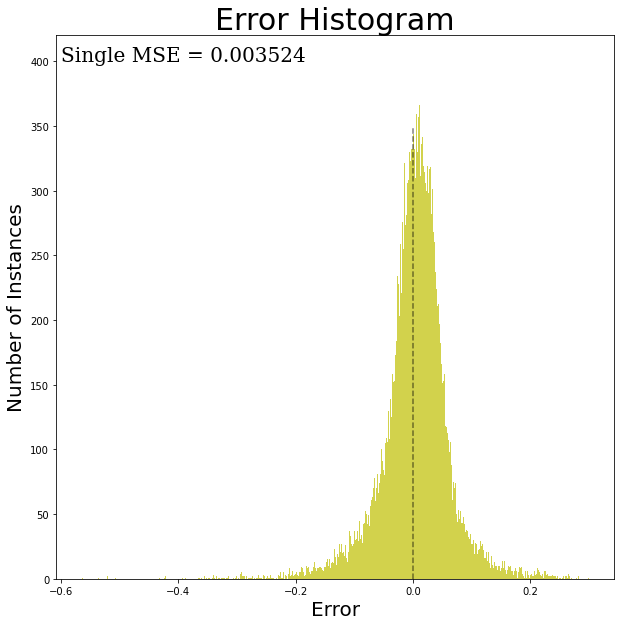

In [ ]:
#Histogram Yellow ONLY
# fixed

predictList = makePredictionsList(modelList, x_valid)
y_pred = np.array(predictList[5])
y_valid = np.array(y_valid)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
y= y_pred.flatten()-y_valid.flatten()
y = np.array(y)
y = sorted(y)

axs.set_ylim(bottom=0, top = 420)
axs.plot([0,0],[0,350], '--', alpha=0.5, color='black')


axs.hist(y[:int(len(y))], bins = 1000, color = 'y', alpha = 0.7)
#axs[1].hist(y[int(.99*len(y)):])

font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 20}
axs.text(-.6, 400, f"Single MSE = {round(float(np.mean((y_valid-np.array(predictList[5]))**2)), 6)}", fontdict = font)

axs.set_title('Error Histogram', fontsize = 30)
axs.set_xlabel('Error', fontsize = 20)
axs.set_ylabel('Number of Instances', fontsize = 20)
#axs[1].set_title('Percent Error Histogram (Points > 100% error)', fontsize = 30)
#axs[1].set_xlabel('Percent', fontsize = 20)
#axs[1].set_ylabel('Count', fontsize = 20)
#fig.suptitle('Overall Percent Error', fontsize = 50)

fig.savefig('YHistogram.jpg')

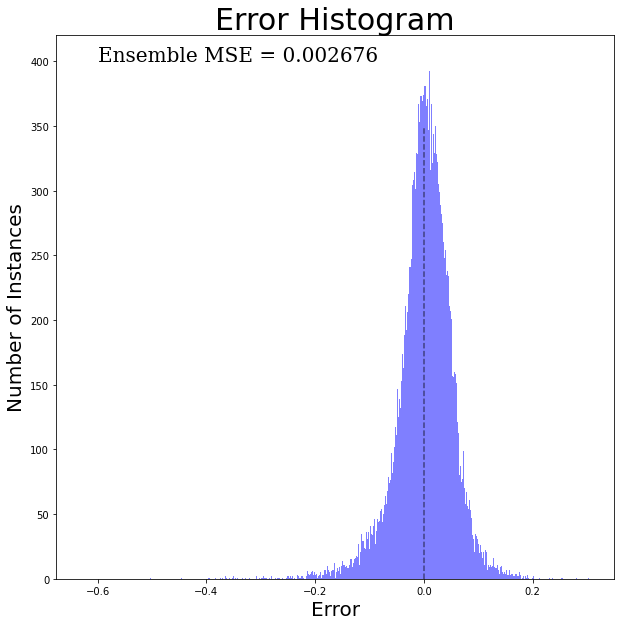

In [ ]:
#Histogram Blue ONLY
# fixed

predictList = makePredictionsList(modelList, x_valid)
y_pred = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
y_valid = np.array(y_valid)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
y= y_pred.flatten()-y_valid.flatten()
y = np.array(y).flatten()
y = sorted(y)
axs.set_ylim(bottom=0, top=420)
axs.plot([0,0],[0,350], '--', alpha=0.5, color='black')

axs.hist(y[:int(len(y))], bins = 1000, color = 'b', alpha = 0.5)
#axs[1].hist(y[int(.99*len(y)):])

axs.text(-.6, 400, f"Ensemble MSE = {round(float(np.mean((y_valid-y_pred)**2)), 6)}", fontdict = font)

axs.set_title('Error Histogram', fontsize = 30)
axs.set_xlabel('Error', fontsize = 20)
axs.set_ylabel('Number of Instances', fontsize = 20)
#axs[1].set_title('Percent Error Histogram (Points > 100% error)', fontsize = 30)
#axs[1].set_xlabel('Percent', fontsize = 20)
#axs[1].set_ylabel('Count', fontsize = 20)
#fig.suptitle('Overall Percent Error', fontsize = 50)

fig.savefig('BHistogram.jpg')

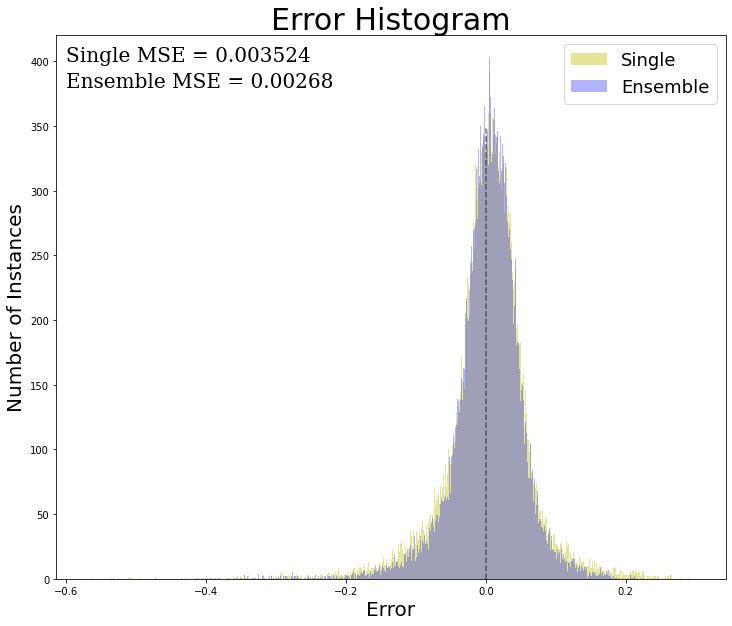

In [ ]:
#Histogram Blue AND Yellow
# fixed

predictList = makePredictionsList(modelList, x_valid)
y_predENS = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
y_predSIN = np.array(predictList[5])
y_valid = np.array(y_valid)
fig, axs = plt.subplots(1, 1, figsize=(12, 10))
yENS = y_predENS.flatten()-y_valid.flatten()
yENS = np.array(yENS).flatten()
ySIN = y_predSIN.flatten()-y_valid.flatten()
ySIN = np.array(ySIN).flatten()
axs.set_ylim(bottom=0, top=420)

axs.hist(ySIN, bins = 1000, color = 'y', alpha = .4, label = 'Single')
axs.hist(yENS, bins = 1000, color = 'b', alpha = .3, label = 'Ensemble')

#axs[1].hist(y[int(.99*len(y)):])
axs.legend()
axs.legend(['Single', 'Ensemble'], loc = 'upper right', prop={'size': 18})

font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 20}
axs.text(-.6, 400, f"Single MSE = {round(float(np.mean((y_valid-y_predSIN)**2)), 6)}", fontdict = font)
axs.text(-.6, 380, f"Ensemble MSE = {round(float(np.mean((y_valid-y_predENS)**2)), 6)}", fontdict = font)

axs.plot([0,0],[0,350], '--', alpha=0.5, color='black')
axs.set_title('Error Histogram', fontsize = 30)
axs.set_xlabel('Error', fontsize = 20)
axs.set_ylabel('Number of Instances', fontsize = 20)
#axs[1].set_title('Percent Error Histogram (Points > 100% error)', fontsize = 30)
#axs[1].set_xlabel('Percent', fontsize = 20)
#axs[1].set_ylabel('Count', fontsize = 20)
#fig.suptitle('Overall Percent Error', fontsize = 50)

fig.savefig('BothHistogram.jpg')

In [ ]:
# Scatterplot Yellow ONLY
# fixed

# Make Scatterplot Error graph with GEOMETRIC MEAN, blue is all networks, yellow is average
# Still need to figure out how to get R^2 value for individual networks

from sklearn.metrics import r2_score
predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig, axe = plt.subplots(figsize=(15, 15), dpi=300)
#for i in range(numOutputs):
#  x = np.transpose(y_valid)[i]

for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  for model in range(numNetworks):
    if model == 5 :
      plt.plot(x, np.transpose(predictList[model])[i], '.', alpha=0.3, color = 'y', label = 'Individual Networks')
#for i in range(numOutputs):
#  x = np.transpose(y_valid)[i]
#  plt.plot(x, np.transpose(y_pred)[i], '.', alpha=0.3, color = 'navy', label = 'Ensemble Network')

a, b = 0, .6
plt.axis([0, .7, 0, .7])
plt.plot([a,b],[a,b], '--', color='black', alpha = .5)
plt.title('Scatter Plot Error', fontsize = 30)
plt.xlabel('y actual', fontsize = 20)
plt.ylabel('y predicted', fontsize = 20)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 24})
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 24}
# axe.text(.025, 0.65, f"Ensemble Network R^2 = {round(r2_score(np.array(y_pred).flatten(), np.array(y_valid).flatten()), 5)}", fontdict = font)
axe.text(.02, 0.66, f"Individual Networks R^2 = {round(r2_score(np.array(predictList[5]).flatten(), list(np.array(y_valid).flatten())), 5)}", fontdict = font)
axe.text(.02, 0.63, f"Individual MSE = {round(float(np.mean((y_valid-np.array(predictList[5]))**2)), 6)}", fontdict = font)

plt.savefig('YSymErrorGeo.jpg')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Scatterplot Blue ONLY
# fixed

# Make Scatterplot Error graph with GEOMETRIC MEAN, blue is all networks, yellow is average
# Still need to figure out how to get R^2 value for individual networks

from sklearn.metrics import r2_score
predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig, axe = plt.subplots(figsize=(15, 15), dpi=300)

for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  plt.plot(x, np.transpose(y_pred)[i], '.', alpha=0.2, color = 'b', label = 'Ensemble Network')

a, b = 0, .6
plt.axis([0, .7, 0, .7])
plt.plot([a,b],[a,b], '--', color='black', alpha = 0.5)
plt.title('Scatter Plot Error', fontsize = 30)
plt.xlabel('y actual', fontsize = 20)
plt.ylabel('y predicted', fontsize = 20)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 24})
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 20}
axe.text(.025, 0.68, f"Ensemble Network R^2 = {round(r2_score(np.array(y_pred).flatten(), np.array(y_valid).flatten()), 5)}", fontdict = font)
# axe.text(.025, 0.68, f"Individual Networks R^2 = {round(r2_score(np.array(predictList).flatten(), list(np.array(y_valid).flatten())*numNetworks), 5)}", fontdict = font)
#axe.text(.025, 0.65, f"MSE = {round(float(np.mean((y_valid-y_pred)**2)), 6)}", fontdict = font)

plt.savefig('BSymErrorGeo.jpg')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Scatterplot Blue AND Yellow
# Make Scatterplot Error graph with GEOMETRIC MEAN, blue is all networks, yellow is average
# Still need to figure out how to get R^2 value for individual networks

from sklearn.metrics import r2_score
predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig, axe = plt.subplots(figsize=(15, 15), dpi=300)
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  for model in range(numNetworks):
    plt.plot(x, np.transpose(predictList[model])[i], '.', alpha=0.3, color = 'y', label = 'Individual Networks')
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  plt.plot(x, np.transpose(y_pred)[i], '.', alpha=0.2, color = 'b', label = 'Ensemble Network')
a, b = 0, .65
plt.axis([0, .75, 0, .75])
plt.plot([a,b],[a,b], '--', color='black', alpha = .5)
plt.title('Scatter Plot Error', fontsize = 30)
plt.xlabel('y actual', fontsize = 20)
plt.ylabel('y predicted', fontsize = 20)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 24})
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 20}
axe.text(.02, 0.69, f"Ensemble Network R^2 = {round(r2_score(np.array(y_pred).flatten(), np.array(y_valid).flatten()), 5)}", fontdict = font)
axe.text(.02, 0.72, f"Individual Networks R^2 = {round(r2_score(np.array(predictList).flatten(), list(np.array(y_valid).flatten())*numNetworks), 5)}", fontdict = font)
sum = 0
for i in range(numNetworks):
  sum += np.mean((y_valid-predictList[i])**2)
sum /= numNetworks
axe.text(.02, .65, f"Avg Individual MSE= {round(float(sum), 6)}", fontdict = font)
axe.text(.02, 0.62, f"Ensemble MSE = {round(float(np.mean((y_valid-y_pred)**2)), 6)}", fontdict = font)

plt.savefig('BothSymErrorGeo.jpg')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Must run confidence interval block for this to run
# accuracy thingy majig
# need to fix and make one plot

y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])
goodX, goodY = [], []
badX, badY = [], []
for i, spectra in enumerate(np.abs(y_pred - y_valid)):
  for j, ele in enumerate(spectra):
    if ele < UQ[i][j]*(2.26216/np.sqrt(numNetworks)):
      goodY.append(y_pred[i][j])
      goodX.append(y_valid[i][j])
    else:
      badY.append(y_pred[i][j])
      badX.append(y_valid[i][j])
print(f'Accuracy = {len(goodX)/(20*len(x_valid))}')
print(f'Total MSE = {np.mean((y_valid-y_pred)**2)}')
fig, ax = plt.subplots(1, figsize = (15,15), dpi=300)
plt.axis([0, .7, 0, .7])


ax.plot(badX, badY, '*', color = 'y', alpha = 0.5)
ax.plot(goodX, goodY, '*', color = 'navy', alpha = 0.3)
a, b = 0, .7
ax.plot([a,b],[a,b], color='black')
ax.set_title('All Points', fontsize = 50)
ax.set_xlabel('y_actual', fontsize = 30)
ax.set_ylabel('y_predicted', fontsize = 30)

font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 20}
ax.text(0.05, 0.65, f"Points Within 95% = {round((len(goodX)/(20*len(x_valid)))*100, 5)}%", fontdict = font)


#ax[1].plot(badX, badY, '*', color = 'y')
#a, b = 0, .4
#ax[1].plot([a,b],[a,b], color='black')
#ax[1].set_title('Bad Points', fontsize = 20)
#ax[1].set(xlabel='y_actual', ylabel='y_predicted')

fig.savefig('AccuracyModel.jpg')

Output hidden; open in https://colab.research.google.com to view.

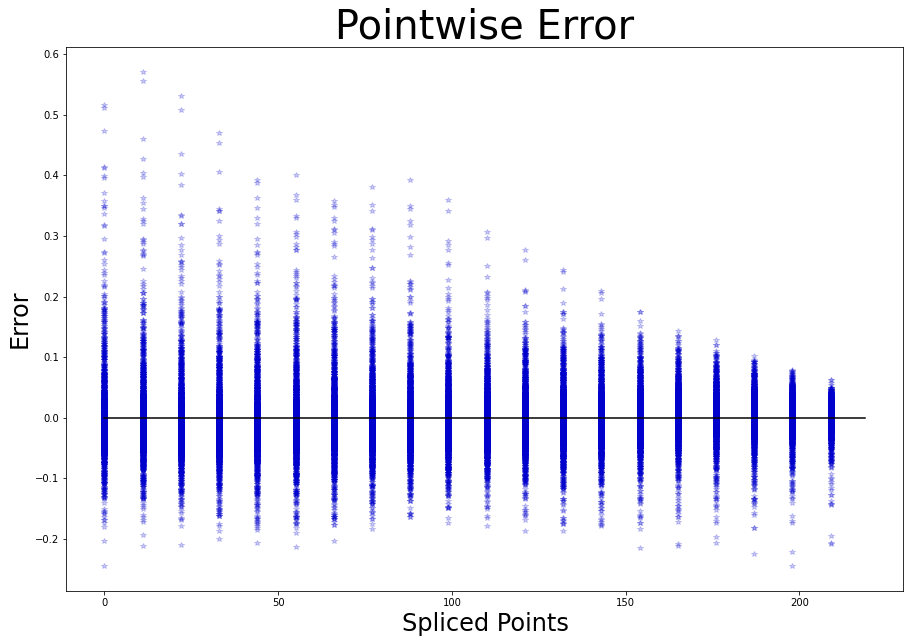

In [ ]:
# Run if you are splicing, if not spliced might be really hard to view
# Second Error graph - shows error for each point

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig = plt.figure(figsize=(15, 10))
for i in range(len(x_valid)):
  plt.plot(x, y_valid[i] - y_pred[i], '*', color = 'mediumblue', alpha = 0.2)
plt.plot([0, 219],[0,0], color = 'black')
plt.title('Pointwise Error', fontsize = 40)
plt.ylabel('Error', fontsize = 24)
plt.xlabel('Spliced Points', fontsize = 24)
plt.savefig('PointWiseError.jpg')
plt.show()

In [ ]:
# Saving Code Block: uploads models under names to google drive, must move these to the Shared Drive

names = ['PredictCompare.jpg', 'PredictCompare2.jpg', 'YSymErrorGeo.jpg', 'BSymErrorGeo.jpg', 'BothSymErrorGeo.jpg', 'PointWiseError.jpg', 'MSE_Plot.jpg', 'Confidence.jpg','YHistogram.jpg', 'BHistogram.jpg', 'BothHistogram.jpg', 'AccuracyModel.jpg', 'SpecificData.jpg', 'PointWiseSTD.jpg']
for name in names:
  try:
    colab_link = name
    gdrive_link = "/content/drive/My Drive/Colab Notebooks/Models"
    shutil.copy(colab_link, gdrive_link)
  except:
    print(f'{name} not downloaded')

BSymErrorGeo.jpg not downloaded
BHistogram.jpg not downloaded
AccuracyModel.jpg not downloaded
